### Load CIFAR-100 Database and Convert image to (224,224) size
Because most prebuilt CNNs such as VGG16 and VGG19 are not accept mall images. For the first time running the trainning, we need to convert all images from $32 \times 32$ pixels to $224 \times 224$ pixels. Run code below to generate a training, validation and testing dataset.

In [1]:
from data.convert import convert
convert()

Using TensorFlow backend.


## Import Cifar100 Dataset
In the code cell below, we import a dataset of dog images. We populate a few variables through the use of the load_files function from the scikit-learn library:

- train_files, valid_files, test_files - numpy arrays containing file paths to images
- train_targets, valid_targets, test_targets - numpy arrays containing onehot-encoded classification labels
- dog_names - list of string-valued dog breed names for translating labels

In [69]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path, subset_size=1):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 100)
    limit = int(len(files)*subset_size)
    return files[:limit], targets[:limit]

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train', 0.1)
valid_files, valid_targets = load_dataset('data/validation', 0.1)
test_files, test_targets = load_dataset('data/test', 0.1)

# load list of image categories
cifar_tags = [item[20:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(cifar_tags))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

There are 100 total categories.
There are 6000 total images.

There are 4500 training images.
There are 500 validation images.
There are 1000 test images.


### Visualize the First 24 Training Images

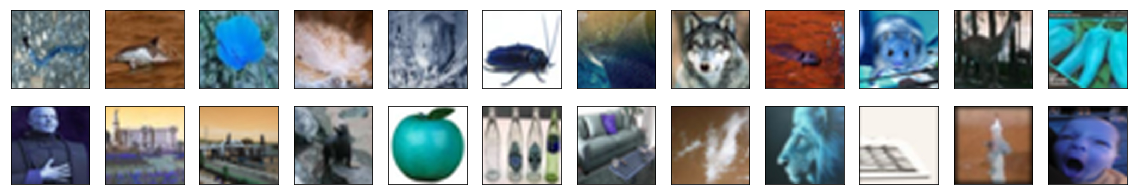

In [70]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(24):
    img = mpimg.imread(train_files[i])
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(img)

### Pre-process the Data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Rescale the Image by Dividing Every Pixel in Every Image by 255
We rescale the images by dividing every pixel in every image by 255.

In [71]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 1000/1000 [00:01<00:00, 575.85it/s]


### Visualize Original and Augmented Images

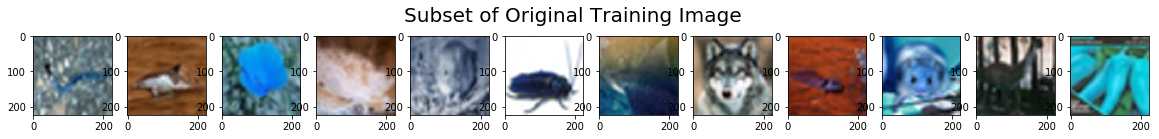

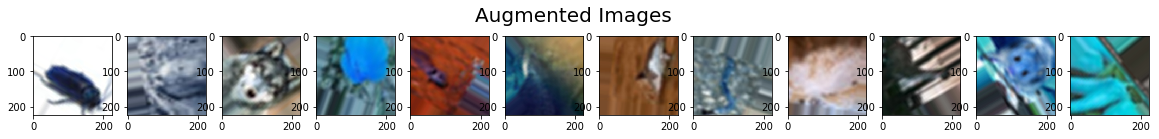

In [72]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Image', fontsize = 20)
plt.show()

datagen_preview = ImageDataGenerator(
        shear_range=0.2,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_preview.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### Define data generator

In [77]:
from keras.preprocessing.image import ImageDataGenerator

def generate(batch, train_tensors, train_targets, valid_tensors, valid_targets):
    """Data generation and augmentation

    # Arguments
        batch: Integer, batch size.
        size: Integer, image size.

    # Returns
        train_generator: train set generator
        validation_generator: validation set generator
        count1: Integer, number of train set.
        count2: Integer, number of test set.
    """

    #  Using the data Augmentation in traning data
    datagen1 = ImageDataGenerator(
        shear_range=0.2,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

    datagen2 = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = datagen1.flow(
        train_tensors,
        train_targets,
        batch_size=batch)

    validation_generator = datagen2.flow(
        valid_tensors,
        valid_targets,
        batch_size=batch)
    """
    count1 = 0
    for root, dirs, files in os.walk(ptrain):
        for each in files:
            count1 += 1

    count2 = 0
    for root, dirs, files in os.walk(pval):
        for each in files:
            count2 += 1
    """
    
    count1 = len(train_tensors)
    count2 = len(valid_tensors)
    return train_generator, validation_generator, count1, count2

## 7. Define the Model Architecture

In [78]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
__________

In [79]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint 

epochs = 50
batch = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
"""
model.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=epochs, batch_size=batch_size,
          callbacks=[checkpointer], verbose=2)
"""
train_generator, validation_generator, count1, count2 = generate(batch, train_tensors, train_targets, valid_tensors, valid_targets)

print(count1, count2)
model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=count1 // batch,
                    validation_steps=count2 // batch,
                    epochs=epochs, verbose=2, callbacks=[checkpointer])

4500 500
Epoch 1/50
 - 51s - loss: 4.5283 - acc: 0.0190 - val_loss: 4.6097 - val_acc: 0.0187

Epoch 00001: val_loss improved from inf to 4.60975, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/50
 - 50s - loss: 4.4111 - acc: 0.0290 - val_loss: 4.6065 - val_acc: 0.0187

Epoch 00002: val_loss improved from 4.60975 to 4.60653, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/50


In [13]:
from mobilenet_v2 import MobileNetv2

mn_model = MobileNetV2(weights=None, include_top=False, 
             input_shape=x_train.shape[1:], classes=10)

mn_model.summary()

ModuleNotFoundError: No module named 'mobilenetv2'

In [4]:
print(keras.__version__)

2.1.5
